In [23]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from plotnine import *
import plotnine
import missingno as msno
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium

# 마이너스 폰트 깨짐 현상 수정
mpl.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
path = '/usr/share/fonts/truetype/naver-d2coding/D2Coding-Ver1.3.2-20180524-all.ttc'
font_name = fm.FontProperties(fname=path, size=15).get_name()
plt.rc('font', family=font_name)

# csv 파일 읽어오기
park_df = pd.read_csv('/home/vscode/analysisdev/data6/전국도시공원표준데이터.csv', encoding='euc-kr')
park_df.drop(['공원보유시설(운동시설)', '공원보유시설(유희시설)', '공원보유시설(편익시설)', '공원보유시설(교양시설)',
       '공원보유시설(기타시설)', '지정고시일', '관리기관명', 'Unnamed: 19'], axis=1, inplace=True)

park_df.shape

(18867, 12)

In [24]:
park_df.columns

Index(['관리번호', '공원명', '공원구분', '소재지도로명주소', '소재지지번주소', '위도', '경도', '공원면적',
       '전화번호', '데이터기준일자', '제공기관코드', '제공기관명'],
      dtype='object')

In [25]:
park_df.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명
0,42790-00004,화천 어린이공원1,어린이공원,강원도 화천군 화천읍 아리 256-1번지 일원,강원도 화천군 화천읍 아리 256-1번지 일원,38.105568,127.707075,1048.0,033-440-2467,2018-08-10,4310000,강원도 화천군
1,42790-00004,화천 어린이공원3,어린이공원,강원도 화천군 산수화로5길 24-5,강원도 화천군 화천읍 중리 191-25번지 일원,38.108973,127.708868,1760.0,033-440-2467,2018-08-10,4310000,강원도 화천군
2,42790-00004,화천 어린이공원4,어린이공원,강원도 화천군 산천어길 206,강원도 화천군 화천읍 신읍리 658-4번지 일원,38.114549,127.702736,1511.0,033-440-2467,2018-08-10,4310000,강원도 화천군
3,42790-00008,화천 어린이공원8,어린이공원,강원도 화천군 산수화로8,강원도 화천군 화천읍 아리 244-10번지 일원,38.106931,127.706165,752.0,033-440-2467,2018-08-10,4310000,강원도 화천군
4,42790-00008,사내 어린이공원,어린이공원,강원도 화천군 사내면 사창리 969-4번지 일원,강원도 화천군 사내면 사창리 969-4번지 일원,38.069006,127.523321,1385.0,033-440-2467,2018-08-10,4310000,강원도 화천군


In [26]:
park_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18867 entries, 0 to 18866
Data columns (total 12 columns):
관리번호        18867 non-null object
공원명         18867 non-null object
공원구분        18867 non-null object
소재지도로명주소    8762 non-null object
소재지지번주소     17748 non-null object
위도          18867 non-null float64
경도          18867 non-null float64
공원면적        18867 non-null float64
전화번호        17820 non-null object
데이터기준일자     18867 non-null object
제공기관코드      18867 non-null object
제공기관명       18867 non-null object
dtypes: float64(3), object(9)
memory usage: 1.7+ MB


In [27]:
# 누락데이터 확인
park_df.isnull().sum()

관리번호            0
공원명             0
공원구분            0
소재지도로명주소    10105
소재지지번주소      1119
위도              0
경도              0
공원면적            0
전화번호         1047
데이터기준일자         0
제공기관코드          0
제공기관명           0
dtype: int64

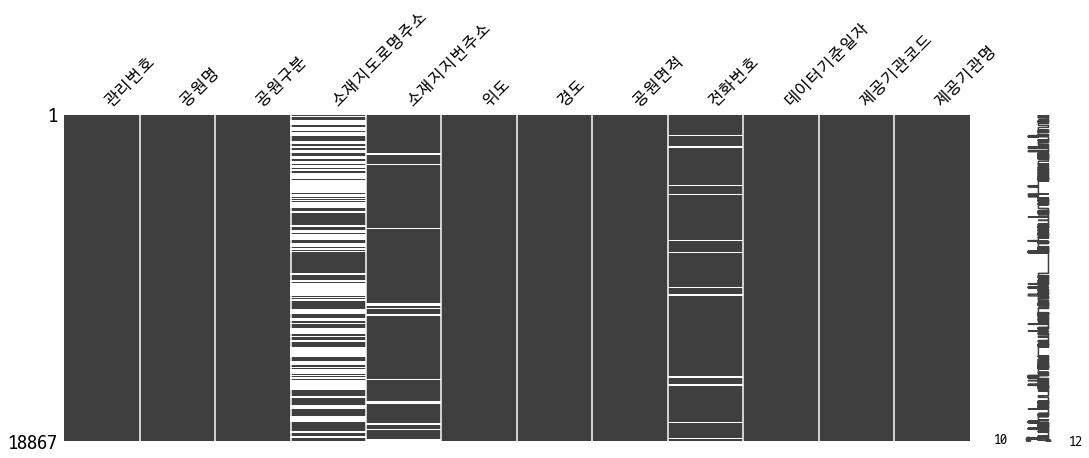

In [28]:
# 결측치 확인
msno.matrix(park_df, figsize=(18, 6))

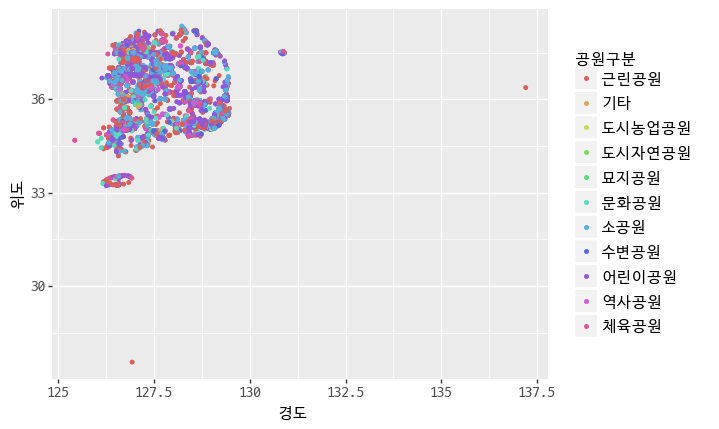

<ggplot: (8733321242961)>

In [30]:
(ggplot(park_df)
+ aes(x='경도', y='위도', color='공원구분')
+ geom_point(alpha=1, size=1)
+ theme(text=element_text(fontproperties=font_name))
+ scale_fill_gradient(low='blue', high='green')
)

In [31]:
# 공원면적 정규화
park_df['공원면적비율'] = park_df['공원면적'].apply(lambda x: np.sqrt(x) * 0.01)
park_df['공원면적비율'].head()

0    0.323728
1    0.419524
2    0.388716
3    0.274226
4    0.372156
Name: 공원면적비율, dtype: float64

In [33]:
park_df['소재지도로명주소'].fillna(park_df['소재지지번주소'], inplace=True)
park_df['소재지도로명주소'].isnull().sum()

0

In [34]:
park_df['소재지도로명주소'].head()

0     강원도 화천군 화천읍 아리 256-1번지 일원
1           강원도 화천군 산수화로5길 24-5
2              강원도 화천군 산천어길 206
3                 강원도 화천군 산수화로8
4    강원도 화천군 사내면 사창리 969-4번지 일원
Name: 소재지도로명주소, dtype: object

In [38]:
park_df['시도'] = park_df['소재지도로명주소'].str.split(' ', expand=True)[0]
park_df.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,공원면적비율,시도,구군
0,42790-00004,화천 어린이공원1,어린이공원,강원도 화천군 화천읍 아리 256-1번지 일원,강원도 화천군 화천읍 아리 256-1번지 일원,38.105568,127.707075,1048.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.323728,강원도,화천군
1,42790-00004,화천 어린이공원3,어린이공원,강원도 화천군 산수화로5길 24-5,강원도 화천군 화천읍 중리 191-25번지 일원,38.108973,127.708868,1760.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.419524,강원도,화천군
2,42790-00004,화천 어린이공원4,어린이공원,강원도 화천군 산천어길 206,강원도 화천군 화천읍 신읍리 658-4번지 일원,38.114549,127.702736,1511.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.388716,강원도,화천군
3,42790-00008,화천 어린이공원8,어린이공원,강원도 화천군 산수화로8,강원도 화천군 화천읍 아리 244-10번지 일원,38.106931,127.706165,752.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.274226,강원도,화천군
4,42790-00008,사내 어린이공원,어린이공원,강원도 화천군 사내면 사창리 969-4번지 일원,강원도 화천군 사내면 사창리 969-4번지 일원,38.069006,127.523321,1385.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.372156,강원도,화천군


In [39]:
park_df['구군'] = park_df['소재지도로명주소'].str.split(' ', expand=True)[1]
park_df.head()

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,공원면적비율,시도,구군
0,42790-00004,화천 어린이공원1,어린이공원,강원도 화천군 화천읍 아리 256-1번지 일원,강원도 화천군 화천읍 아리 256-1번지 일원,38.105568,127.707075,1048.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.323728,강원도,화천군
1,42790-00004,화천 어린이공원3,어린이공원,강원도 화천군 산수화로5길 24-5,강원도 화천군 화천읍 중리 191-25번지 일원,38.108973,127.708868,1760.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.419524,강원도,화천군
2,42790-00004,화천 어린이공원4,어린이공원,강원도 화천군 산천어길 206,강원도 화천군 화천읍 신읍리 658-4번지 일원,38.114549,127.702736,1511.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.388716,강원도,화천군
3,42790-00008,화천 어린이공원8,어린이공원,강원도 화천군 산수화로8,강원도 화천군 화천읍 아리 244-10번지 일원,38.106931,127.706165,752.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.274226,강원도,화천군
4,42790-00008,사내 어린이공원,어린이공원,강원도 화천군 사내면 사창리 969-4번지 일원,강원도 화천군 사내면 사창리 969-4번지 일원,38.069006,127.523321,1385.0,033-440-2467,2018-08-10,4310000,강원도 화천군,0.372156,강원도,화천군


In [40]:
park_df[['위도', '경도']].describe()

,위도,경도
count,18867.000000,18867.000000
mean,36.357159,127.535903
std,1.062241,0.879717
min,27.551606,125.430955
25%,35.277526,126.883708
50%,36.393456,127.131717
75%,37.413196,128.406352
max,38.350990,137.202661


In [42]:
park_loc_notnull = park_df.loc[(park_df['위도'] > 32) & (park_df['경도'] < 132) & park_df['시도'].notnull()]
park_loc_notnull.shape

(18865, 15)

In [49]:
park_df.loc[(park_df['위도'] < 26) | (park_df['경도'] >= 132)]

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,공원면적비율,시도,구군
13695,43113-00080,근린공원5(만수공원),근린공원,충청북도 청주시 흥덕구 오송읍 만수리 512,충청북도 청주시 흥덕구 오송읍 만수리 512,36.374204,137.202661,33258.0,043-201-4433,2019-06-21,5710000,충청북도 청주시,1.823678,충청북도,청주시


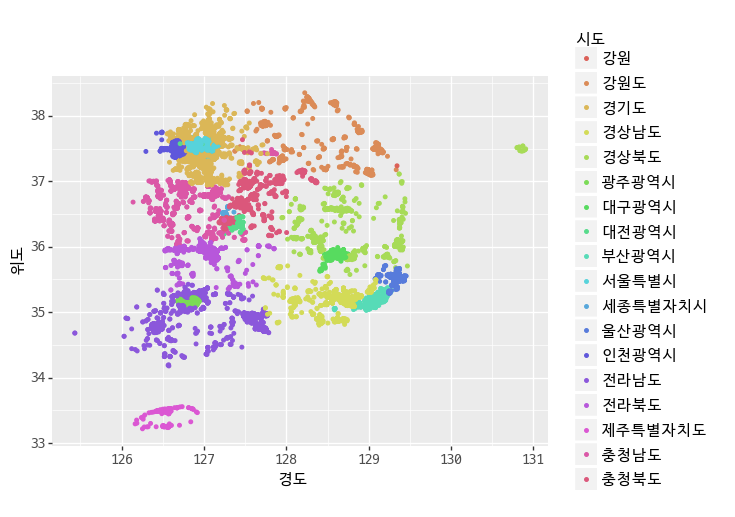

<ggplot: (8733321133873)>

In [50]:
(ggplot(park_loc_notnull)
+ aes(x='경도', y='위도', color='시도')
+ geom_point(alpha=1, size=1)
+ theme(text=element_text(fontproperties=font_name))
+ scale_fill_gradient(low='blue', high='green')
)

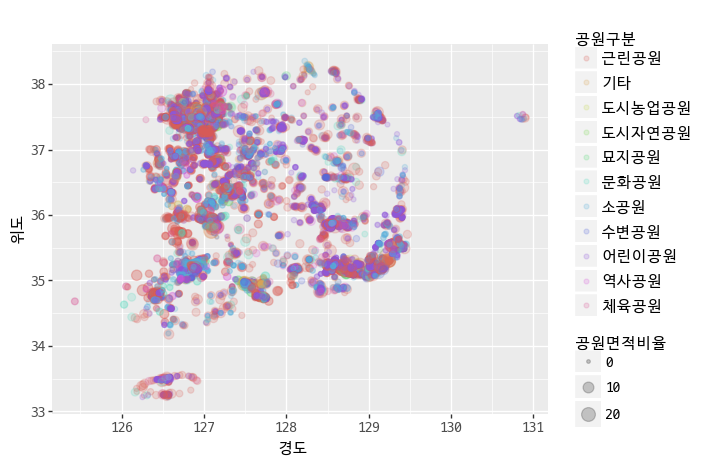

<ggplot: (8733321087317)>

In [51]:
(ggplot(park_loc_notnull)
+ aes(x='경도', y='위도', color='공원구분', size='공원면적비율')
+ geom_point(alpha=0.2)
+ theme(text=element_text(fontproperties=font_name))
+ scale_fill_gradient(low='blue', high='green')
)

In [53]:
# 시도별로 합계 데이터를 출력
park_do = pd.DataFrame(park_df['시도'].value_counts())
park_do_normalize = pd.DataFrame(park_df['시도'].value_counts(normalize=True))
park_sido = park_do.merge(park_do_normalize, left_index=True, right_index=True).reset_index()
park_sido.columns = ['시도', '합계', '비율']
park_sido.sort_values(by=['합계'], ascending=False)
park_sido

,시도,합계,비율
0,경기도,3703,0.196269
1,전라남도,2047,0.108496
2,경상남도,1825,0.096730
3,서울특별시,1779,0.094292
4,충청남도,1723,0.091323
5,전라북도,1139,0.060370
6,충청북도,915,0.048497
7,경상북도,906,0.048020
8,울산광역시,887,0.047013
9,강원도,738,0.039116


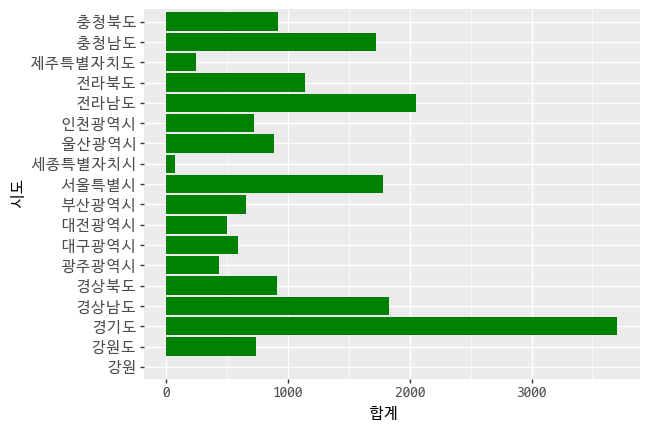

<ggplot: (8733318136005)>

In [55]:
(ggplot(park_sido.sort_values(by=['합계'], ascending=False))
+ aes(x='시도', y='합계')
+ geom_bar(stat='identity', position='dodge', fill='green')
+ coord_flip()
+ theme(text=element_text(fontproperties=font_name))
)

In [87]:
import requests
KAKAO_API_KEY = 'bceac8fa829e15e03abd026e688b94c1'
def netGetGeocoder(query):
    url  = '''
    https://dapi.kakao.com/v2/local/search/address.json?query={0}
    '''.format(query)
    headers = {
        'Authorization':'KakaoAK {0}'.format(KAKAO_API_KEY)
    }
    # API 쿼리 수행
    res = requests.get( url , headers=headers )
    res = res.json()
    if len(res['documents']) > 0:
        # 데이터 리턴 : 주소, 위도, 경도, 질의어 순으로 튜플 형태로 리턴     
        return [res['documents'][0]['address_name'], res['documents'][0]['y'], res['documents'][0]['x']]
    print(len(res['documents']))

In [88]:
park_loc_null = park_df.loc[(park_df['위도'] < 26) | (park_df['경도'] >= 132)]
park_loc_null

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,전화번호,데이터기준일자,제공기관코드,제공기관명,공원면적비율,시도,구군
13695,43113-00080,근린공원5(만수공원),근린공원,충청북도 청주시 흥덕구 오송읍 만수리 512,충청북도 청주시 흥덕구 오송읍 만수리 512,36.374204,137.202661,33258.0,043-201-4433,2019-06-21,5710000,충청북도 청주시,1.823678,충청북도,청주시


In [94]:
result = netGetGeocoder( park_loc_null['소재지도로명주소'].values )
print(result)

['충북 청주시 흥덕구 오송읍 만수리 512', '36.63146824591817', '127.3320857333021']


In [101]:
sr.replace(park_df.loc[13695]['위도'], result[1])
sr.replace(park_df.loc[13695]['경도'], result[2])

AttributeError: 'str' object has no attribute 'loc'

In [91]:
park_df.loc[13695]

관리번호                     43113-00080
공원명                      근린공원5(만수공원)
공원구분                            근린공원
소재지도로명주소    충청북도 청주시 흥덕구 오송읍 만수리 512
소재지지번주소     충청북도 청주시 흥덕구 오송읍 만수리 512
위도                           36.3742
경도                           137.203
공원면적                           33258
전화번호                    043-201-4433
데이터기준일자                   2019-06-21
제공기관코드                       5710000
제공기관명                       충청북도 청주시
공원면적비율                       1.82368
시도                              충청북도
구군                               청주시
Name: 13695, dtype: object